In [2]:
# imports
from pathlib import Path
import geopandas as gpd
import rasterio


In [3]:
# initialize paths etc.
url = "https://data.cityofnewyork.us/api/geospatial/qb5r-6dgf?method=export&format=Shapefile"
data_path = Path("data")

In [5]:
# pull down bldg shp via url
bldg_gdf = gpd.read_file(filename=url, engine="pyogrio")


In [27]:
bldg_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
# to_crs 2263
bldg_gdf.to_crs(epsg="2263",inplace=True)
# export gdf as geoparquet
out_data_name = "buildings"
file_ext = "parquet"
bldg_gdf.to_parquet(data_path / f"{out_data_name}.{file_ext}")

In [ ]:
bldg_gdf.crs

In [32]:
# read geoparquet into a gdf
bldg_gdf = gpd.read_parquet(data_path / f"{out_data_name}.{file_ext}")

print(f"num of rows in bldg dataset: {len(bldg_gdf)}")

num of rows in bldg dataset: 1083122


In [38]:
# calculate roof height relative to sealevel, not grade
bldg_gdf["roof_hgt_from_sealvl"] = (bldg_gdf.heightroof + bldg_gdf.groundelev).round(0)

In [ ]:
bldg_gdf.head()

In [47]:
# subset geoparquet to only include MN

mn_bldg_gdf = bldg_gdf.query("base_bbl.str.startswith('1')")

print(f"num of rows in mn bldg dataset: {len(mn_bldg_gdf)}")

num of rows in mn bldg dataset: 45336


<Axes: >

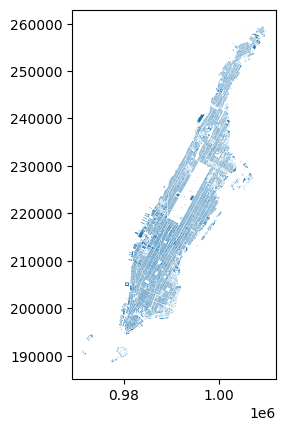

In [48]:
mn_bldg_gdf.plot()

In [ ]:
# rasterize SI bldg footprints
# use clipped landcover dataset as shape and transform reference